Yale의 Endowment Fund를 운용하는 David Swensen이 주장했다고 알려진 전략입니다. 미국 주식 30%, 미국 부동산 20%, 선진국 주식 15%, 신흥국 주식 5%, 미국 장기채 15%, 미국 물가연동채 15%를 가져갑니다.

In [1]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import backtrader as bt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pyfolio as pf
import quantstats
import math
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)

C:\ProgramData\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


미국 부동산 ETF인 VNQ가 2004년 9월 29일부터 있으므로 그때부터 시작합니다.

In [4]:
start = '2004-09-29'
end = '2021-04-30'

vti = web.DataReader('VTI', 'yahoo', start, end)['Adj Close'].to_frame("vti_Close")
vnq = web.DataReader('VNQ', 'yahoo', start, end)['Adj Close'].to_frame("vnq_Close")
efa = web.DataReader('EFA', 'yahoo', start, end)['Adj Close'].to_frame("efa_Close")
eem = web.DataReader('EEM', 'yahoo', start, end)['Adj Close'].to_frame("eem_Close")
tlt = web.DataReader('TLT', 'yahoo', start, end)['Adj Close'].to_frame("tlt_Close")
tip = web.DataReader('TIP', 'yahoo', start, end)['Adj Close'].to_frame("tip_Close")

In [5]:
vnq.head()

,vnq_Close
Date,
2004-09-29,23.794544
2004-09-30,23.985474
2004-10-01,24.429386
2004-10-04,24.534403
2004-10-05,24.529629


일단 모델 포트폴리오로, 매일 비중을 맞추는 것으로 생각하고 만듭니다. 거래비용은 생략합니다.

In [6]:
vti_return = vti.pct_change(periods=1)
vnq_return = vnq.pct_change(periods=1)
efa_return = efa.pct_change(periods=1)
eem_return = eem.pct_change(periods=1)
tlt_return = tlt.pct_change(periods=1)
tip_return = tip.pct_change(periods=1)

df_return = pd.concat([vti_return, vnq_return, efa_return, eem_return, tlt_return, tip_return], axis=1)

df_return.head()

,vti_Close,vnq_Close,efa_Close,eem_Close,tlt_Close,tip_Close
Date,,,,,,
2004-09-28,NaN,NaN,NaN,NaN,NaN,NaN
2004-09-29,0.002236,NaN,0.003847,0.005272,-0.009725,-0.004205
2004-09-30,0.001673,0.008024,0.003548,0.005245,-0.003839,-0.000096
2004-10-01,0.016147,0.018508,0.015559,0.019130,-0.004995,-0.004703
2004-10-04,0.003288,0.004299,0.001532,0.017065,0.001487,-0.002411


In [7]:
df_return['Yale_return'] = df_return['vti_Close']*0.3+df_return['vnq_Close']*0.2+df_return['efa_Close']*0.15+df_return['eem_Close']*0.05+df_return['tlt_Close']*0.15+df_return['tip_Close']*0.15
df_return.head()

,vti_Close,vnq_Close,efa_Close,eem_Close,tlt_Close,tip_Close,Yale_return
Date,,,,,,,
2004-09-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-09-29,0.002236,NaN,0.003847,0.005272,-0.009725,-0.004205,NaN
2004-09-30,0.001673,0.008024,0.003548,0.005245,-0.003839,-0.000096,0.002311
2004-10-01,0.016147,0.018508,0.015559,0.019130,-0.004995,-0.004703,0.010381
2004-10-04,0.003288,0.004299,0.001532,0.017065,0.001487,-0.002411,0.002791


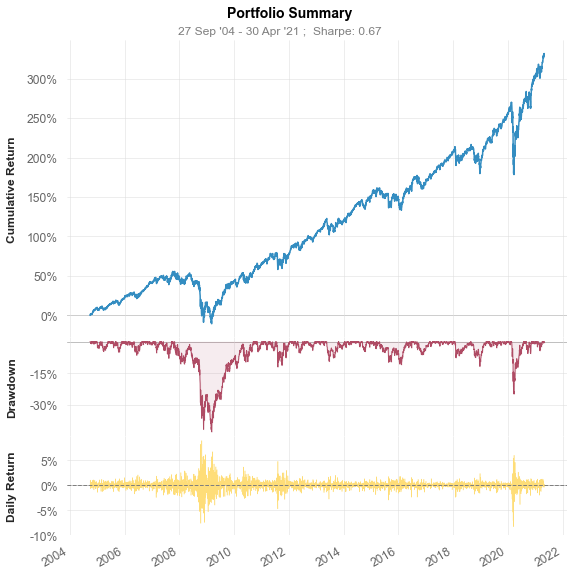

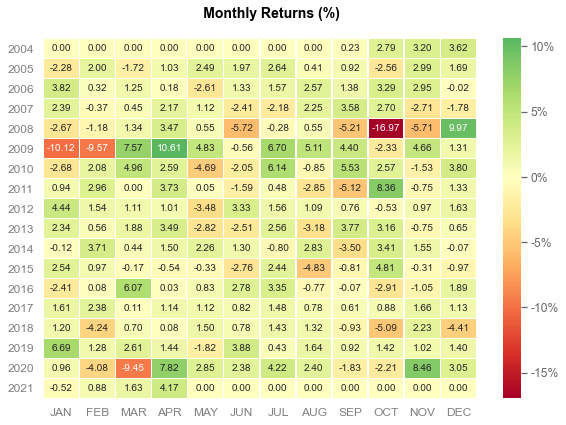

In [8]:
quantstats.reports.plots(df_return['Yale_return'], mode='basic')

매일 리밸런싱을 한 결과 연 복리 수익률 9.19%, 샤프 비율 0.67, MDD -43% 정도입니다. 연 변동성은 14.82%로 주식과 부동산(REITs) 비중이 높고 채권을 적게 가져가 샤프 비율로 볼 때 그렇게 매력적이지는 않습니다. 

In [9]:
quantstats.reports.metrics(df_return['Yale_return'], mode='full')

                           Strategy
-------------------------  ----------
Start Period               2004-09-28
End Period                 2021-04-30
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          330.22%
CAGR%                      9.19%
Sharpe                     0.67
Sortino                    0.95
Max Drawdown               -42.6%
Longest DD Days            1048
Volatility (ann.)          14.82%
Calmar                     0.22
Skew                       -0.16
Kurtosis                   14.68

Expected Daily %           0.03%
Expected Monthly %         0.73%
Expected Yearly %          8.44%
Kelly Criterion            7.04%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.5%
Expected Shortfall (cVaR)  -1.5%

Payoff Ratio               0.91
Profit Factor              1.15
Common Sense Ratio         1.1
CPC Index                  0.58
Tail Ratio                 0.96
Outlier Win Ratio          4.8
Outlier Loss Ratio         4.48

위에서 한 것처럼 그냥 만들어도 되지만, 백테스트에 많이 쓰이는 Backtrader 패키지를 한번 사용해 보겠습니다. Input 형식을 맞추어야 합니다.

In [10]:
vti = vti.rename({'vti_Close':'Close'}, axis='columns')
vnq = vnq.rename({'vnq_Close':'Close'}, axis='columns')
efa = efa.rename({'efa_Close':'Close'}, axis='columns')
eem = eem.rename({'eem_Close':'Close'}, axis='columns')
tlt = tlt.rename({'tlt_Close':'Close'}, axis='columns')
tip = tip.rename({'tip_Close':'Close'}, axis='columns')

for column in ['Open', 'High', "Low"]:
    vti[column] = vti["Close"]
    vnq[column] = vnq["Close"]
    efa[column] = efa["Close"]
    eem[column] = eem["Close"]
    tlt[column] = tlt["Close"]
    tip[column] = tip["Close"]

In [11]:
vnq.head()

,Close,Open,High,Low
Date,,,,
2004-09-29,23.794544,23.794544,23.794544,23.794544
2004-09-30,23.985474,23.985474,23.985474,23.985474
2004-10-01,24.429386,24.429386,24.429386,24.429386
2004-10-04,24.534403,24.534403,24.534403,24.534403
2004-10-05,24.529629,24.529629,24.529629,24.529629


비중을 맞추어 매수하고 20 거래일마다 리밸런싱하는 전략입니다. 20 거래일은 현실 기준으로 약 1개월입니다.

In [18]:
class AssetAllocation_Yale(bt.Strategy):
    params = (
        ('usequity',0.30),
        ('reits',0.2),
        ('devequity',0.15),
        ('emequity',0.05),
        ('longbond',0.15),
        ('tips',0.15)
    )
    def __init__(self):
        self.VTI = self.datas[0]
        self.VNQ = self.datas[1]
        self.EFA = self.datas[2]
        self.EEM = self.datas[3]
        self.TLT = self.datas[4]
        self.TIP = self.datas[5]
        self.counter = 0
        
    def next(self):
        if  self.counter % 20 == 0:
            self.order_target_percent(self.VTI, target=self.params.usequity)
            self.order_target_percent(self.VNQ, target=self.params.reits)
            self.order_target_percent(self.EFA, target=self.params.devequity)
            self.order_target_percent(self.EEM, target=self.params.emequity)
            self.order_target_percent(self.TLT, target=self.params.longbond)
            self.order_target_percent(self.TIP, target=self.params.tips)
        self.counter += 1

In [19]:
cerebro = bt.Cerebro()

cerebro.broker.setcash(1000000)

VTI = bt.feeds.PandasData(dataname = vti)
VNQ = bt.feeds.PandasData(dataname = vnq)
EFA = bt.feeds.PandasData(dataname = efa)
EEM = bt.feeds.PandasData(dataname = eem)
TLT = bt.feeds.PandasData(dataname = tlt)
TIP = bt.feeds.PandasData(dataname = tip)

cerebro.adddata(VTI)
cerebro.adddata(VNQ)
cerebro.adddata(EFA)
cerebro.adddata(EEM)
cerebro.adddata(TLT)
cerebro.adddata(TIP)

cerebro.addstrategy(AssetAllocation_Yale)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name = 'PyFolio')

results = cerebro.run()
strat = results[0]

portfolio_stats = strat.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)

#quantstats.reports.html(returns, output = 'Report_AssetAllocation_Yale.html', title='AssetAllocation_Yale')

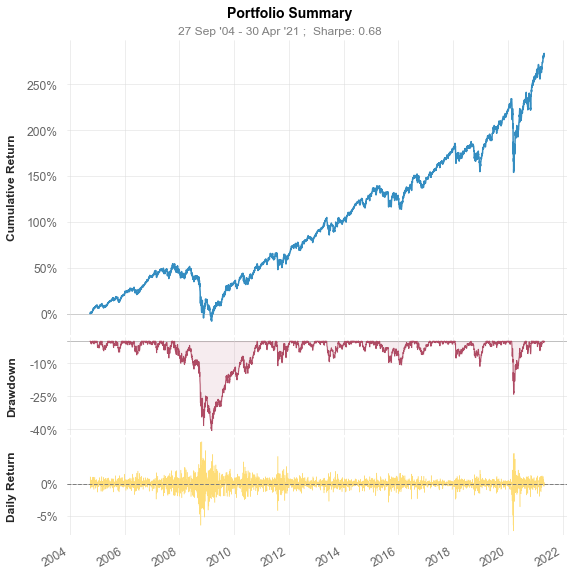

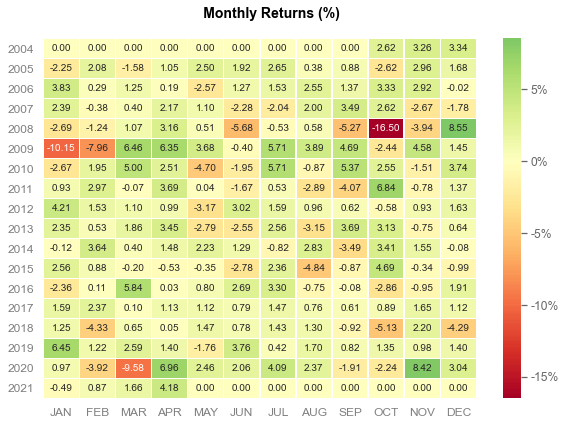

In [20]:
quantstats.reports.plots(returns, mode='basic')

20 거래일마다 리밸런싱으로 바꾸니 연 복리 수익률 8.4%, 샤프 비율 0.68, MDD -41% 수준입니다. 연 변동성 13.1%로 매일 리밸런싱과 샤프 비율 상 큰 차이는 없습니다.

In [21]:
quantstats.reports.metrics(returns, mode='full')

                           Strategy
-------------------------  ----------
Start Period               2004-09-28
End Period                 2021-04-30
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          282.41%
CAGR%                      8.42%
Sharpe                     0.68
Sortino                    0.96
Max Drawdown               -40.51%
Longest DD Days            1099
Volatility (ann.)          13.07%
Calmar                     0.21
Skew                       -0.46
Kurtosis                   10.82

Expected Daily %           0.03%
Expected Monthly %         0.67%
Expected Yearly %          7.74%
Kelly Criterion            6.81%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.32%
Expected Shortfall (cVaR)  -1.32%

Payoff Ratio               0.92
Profit Factor              1.14
Common Sense Ratio         1.1
CPC Index                  0.58
Tail Ratio                 0.96
Outlier Win Ratio          4.18
Outlier Loss Ratio         

월간 데이터를 사용하면 훨씬 더 과거의 결과도 테스트해 볼 수 있습니다. 가장 긴 시계열의 경우 1900년 1월부터 2020년 12월까지의 데이터가 있습니다.

In [22]:
MonthlyReturn = pd.read_excel('MonthlyAssetClassReturn.xlsx')

In [23]:
MonthlyReturn.head()

,Data Index,Broker Call Rate,CPI,T-Bills,S&P 500 Total return,Small Cap Stocks,MSCI EAFE,EEM,US 10 YR,US Corp Bond Return Index,...,International Small Cap Value (Global B/M Small Low),International Large Cap Value (Global B/M Big Low),International Small High Mom (Global mom Small High),International Large High Mom (Global mom Small High),Merrill High Yield,World Stocks,World ex USA,BuyWrite,PutWrite,Bitcoin
0,1900-01-31,NaN,0.013333,0.0025,0.016413,NaN,NaN,NaN,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1900-02-28,NaN,0.000000,0.0025,0.021138,NaN,NaN,NaN,0.011278,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1900-03-31,NaN,0.000000,0.0025,0.011084,NaN,NaN,NaN,0.009758,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1900-04-30,NaN,0.000000,0.0025,0.015894,NaN,NaN,NaN,-0.016107,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1900-05-31,NaN,0.000000,0.0025,-0.044246,NaN,NaN,NaN,0.016023,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


시계열로 바꾸어 주는 것이 사용하기 편합니다. 1열인 Data Index가 월말 날짜이므로, 이 열을 인덱스로 잡습니다.

In [24]:
MonthlyReturn = MonthlyReturn.set_index('Data Index')

In [25]:
MonthlyReturn.head()

,Broker Call Rate,CPI,T-Bills,S&P 500 Total return,Small Cap Stocks,MSCI EAFE,EEM,US 10 YR,US Corp Bond Return Index,GSCI,...,International Small Cap Value (Global B/M Small Low),International Large Cap Value (Global B/M Big Low),International Small High Mom (Global mom Small High),International Large High Mom (Global mom Small High),Merrill High Yield,World Stocks,World ex USA,BuyWrite,PutWrite,Bitcoin
Data Index,,,,,,,,,,,,,,,,,,,,,
1900-01-31,NaN,0.013333,0.0025,0.016413,NaN,NaN,NaN,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-02-28,NaN,0.000000,0.0025,0.021138,NaN,NaN,NaN,0.011278,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-03-31,NaN,0.000000,0.0025,0.011084,NaN,NaN,NaN,0.009758,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-04-30,NaN,0.000000,0.0025,0.015894,NaN,NaN,NaN,-0.016107,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-05-31,NaN,0.000000,0.0025,-0.044246,NaN,NaN,NaN,0.016023,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


필요한 것만 뽑아옵니다. 월간 미국 주식(S&P 500), 미국 부동산, 선진국 주식, 신흥국 주식, 월간 미국 30년 만기 국채, 월간 미국 TIPS 수익률 데이터입니다. 1973년 2월부터 2020년 12월까지 48년 정도 기간의 테스트가 될 것입니다.

In [27]:
Monthly_Yale = MonthlyReturn.loc[:, ['S&P 500 Total return','NAREIT','MSCI EAFE','EEM','US 30 YR','TIPS Series']]
Monthly_Yale = Monthly_Yale.loc[Monthly_Yale.index >= '1973-02-28']
Monthly_Yale['Monthly_Yale'] = Monthly_Yale['S&P 500 Total return']*0.3+Monthly_Yale['NAREIT']*0.2+Monthly_Yale['MSCI EAFE']*0.15+Monthly_Yale['EEM']*0.05+Monthly_Yale['US 30 YR']*0.15+Monthly_Yale['TIPS Series']*0.15

월간 데이터이므로, 일간 데이터 기준인 패키지가 주는 값을 적절히 조정해야 합니다. 1년 12개월 252거래일을 가정합니다. 1973년 2월부터 48년 동안 샤프 비율은 0.960으로 나옵니다. 괜찮기는 한데 Ray Dalio의 All Weather가 눈을 너무 높여 놓았습니다.아래 그림의 제목 하단에 있는 샤프 비율은 무시하고, 직접 계산한 값을 보아야 합니다.

In [28]:
quantstats.stats.sharpe(Monthly_Yale['Monthly_Yale'])/math.sqrt(252/12)

0.9599428949704836

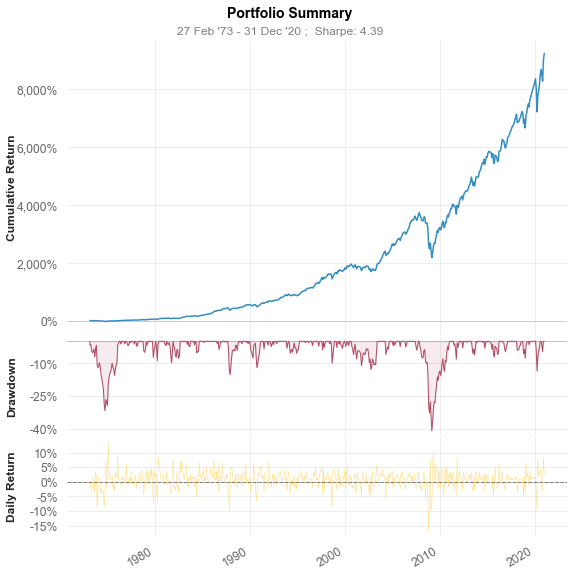

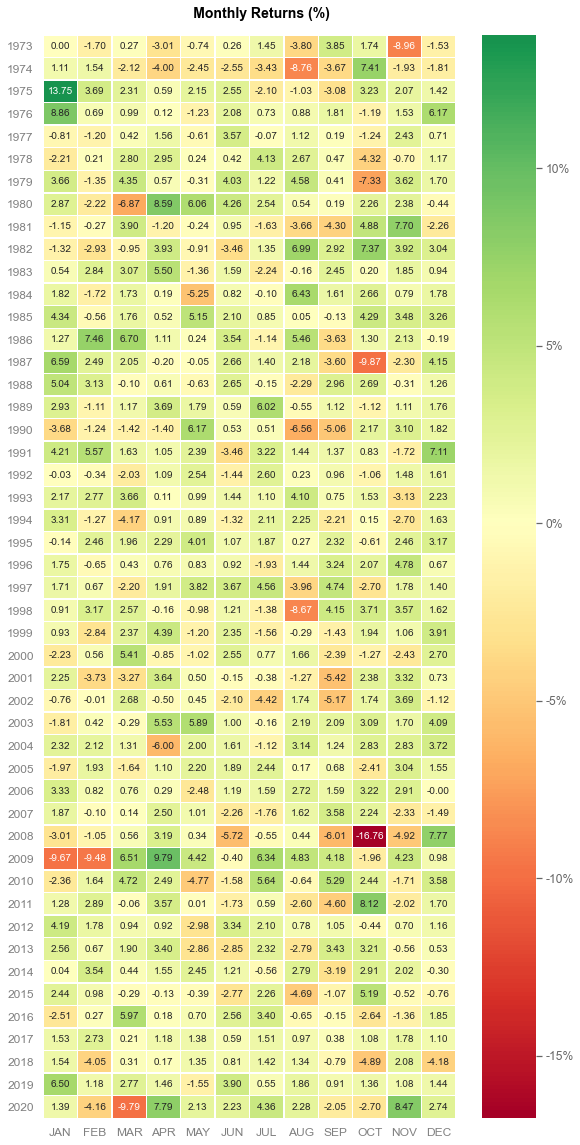

In [29]:
quantstats.reports.plots(Monthly_Yale['Monthly_Yale'], mode='basic')

연 복리 수익률 9.94%, 샤프 비율은 위에서 계산한대로 0.960 (아래 결과는 무시합니다 월간 데이터라 다르게 나옵니다), MDD는 -40.64%입니다. 역시나 주식과 REITs 비중이 높아 방어력은 별로 좋지 않습니다. 

In [30]:
quantstats.reports.metrics(Monthly_Yale['Monthly_Yale'], mode='full')

                           Strategy
-------------------------  ----------
Start Period               1973-02-28
End Period                 2020-12-31
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          9,229.42%
CAGR%                      9.94%
Sharpe                     4.4
Sortino                    7.05
Max Drawdown               -40.64%
Longest DD Days            1158
Volatility (ann.)          48.0%
Calmar                     0.24
Skew                       -0.57
Kurtosis                   3.34

Expected Daily %           0.79%
Expected Monthly %         0.79%
Expected Yearly %          9.91%
Kelly Criterion            34.77%
Risk of Ruin               0.0%
Daily Value-at-Risk        -4.14%
Expected Shortfall (cVaR)  -4.14%

Payoff Ratio               1.05
Profit Factor              2.09
Common Sense Ratio         2.82
CPC Index                  1.46
Tail Ratio                 1.35
Outlier Win Ratio          3.27
Outlier Loss Ratio        